<h1>Bayes classifier with a Gaussian distribution for every class<h1>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from math import sqrt
%matplotlib inline

plt.rcParams["font.size"] = 18
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = 8,6
plt.rcParams['font.serif'] = "Cambria"
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
# First, let's load the CSV files to inspect the data and understand their structure.

import pandas as pd

# Load the datasets

# Load the data (assuming train_df, test_df, val_df have been loaded)
x_train = pd.read_csv('Dataset-3/train_data.csv')
y_train = pd.read_csv('Dataset-3/train_label.csv')
x_test = pd.read_csv('Dataset-3/test_data.csv')
y_test = pd.read_csv('Dataset-3/test_label.csv')
x_val = pd.read_csv('Dataset-3/val_data.csv')
y_val = pd.read_csv('Dataset-3/val_label.csv')

x_train = x_train.values
y_train = y_train.values.flatten()
x_test = x_test.values
y_test = y_test.values.flatten()
x_val = x_val.values
y_val = y_val.values.flatten()

In [3]:
# Function to evaluate the accuracy of predictions
def evaluate_accuracy(y_true, y_pred):
    correct = np.sum(np.array(y_true) == np.array(y_pred))
    return correct / len(y_true)

# Function to evaluate performance and print accuracy and confusion matrix
def evaluate_classifier(y_true, y_pred, dataset_name):
    accuracy = evaluate_accuracy(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"Accuracy on {dataset_name}: {accuracy}")
    plot_confusion_matrix(y_true, y_pred, title=f"Confusion Matrix on {dataset_name}")
    
    return accuracy, cm

In [4]:
def estimate_gaussian_parameters(x_train, y_train):
    classes = np.unique(y_train)
    params = {}
    params_avg_cov = {}
    total_cov = 0
    
    for cls in classes:
        # Select data points for the current class
        class_data = x_train[y_train == cls]
        
        # Estimate mean and covariance
        mean = np.mean(class_data, axis=0)
        cov = np.cov(class_data, rowvar=False)
        
        # Add the covariance to the total
        total_cov += cov
        
        # Store the parameters for this class
        params[cls] = {'mean': mean, 'cov': cov}
    
    # Calculate the average covariance
    avg_cov = total_cov / len(classes)
    for cls in classes:
        params_avg_cov[cls] = {'mean': params[cls]['mean'], 'cov': avg_cov}
    
    return params, params_avg_cov

In [5]:
from scipy.stats import multivariate_normal

# Function to compute the multivariate Gaussian likelihood
def gaussian_pdf(x, mean, cov):
    # Create a multivariate Gaussian distribution object
    dist = multivariate_normal(mean=mean, cov=cov)
    
    # Return the probability density for the point x
    return dist.pdf(x)

# Bayes classifier function
def bayes_classifier(x_train, y_train, test_data, params):
    predictions = []
    classes = np.unique(y_train)

    # Loop over each test data point
    for x in test_data:
        posteriors = {}

        # Calculate posterior probability for each class
        for cls in classes:
            mean = params[cls]['mean']
            cov = params[cls]['cov']

            # Likelihood of x given class
            likelihood = gaussian_pdf(x, mean, cov)

            # Prior is assumed to be uniform, so we only consider the likelihood
            posteriors[cls] = likelihood

        # Assign to the class with the highest posterior
        predicted_class = max(posteriors, key=posteriors.get)
        predictions.append(predicted_class)

    return predictions



In [6]:
# Function to plot confusion matrix with customized font sizes
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))

    # Set title and labels with specific font sizes
    plt.title(title, fontsize=12)
    plt.xlabel('Predicted Label', fontsize=10)
    plt.ylabel('True Label', fontsize=10)

    # Optionally adjust tick label sizes
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.show()


In [7]:
# Estimate the Gaussian parameters from the training data
params, params_avg_cov = estimate_gaussian_parameters(x_train, y_train)

<h1>a. Covariance matrices for all the classes are the same<h1>

In [8]:
train_predictions = bayes_classifier(x_train, y_train, x_train, params_avg_cov)
val_predictions = bayes_classifier(x_train, y_train, x_val, params_avg_cov)
test_predictions = bayes_classifier(x_train, y_train, x_test, params_avg_cov)

# Calculate accuracy for each dataset
train_accuracy = evaluate_accuracy(y_train, train_predictions)
val_accuracy = evaluate_accuracy(y_val, val_predictions)
test_accuracy = evaluate_accuracy(y_test, test_predictions)

# Create a dictionary to hold the data
data = {
    'Dataset': ['Train', 'Validation', 'Test'],
    'Size': [len(x_train), len(x_val), len(x_test)],
    'Accuracy': [train_accuracy, val_accuracy, test_accuracy]
}

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Display the table
print(df)

      Dataset  Size  Accuracy
0       Train  2099  0.535017
1  Validation   299  0.451505
2        Test   599  0.504174



Covariance matrices for all the classes are the same

Accuracy on Test Data: 0.5041736227045075


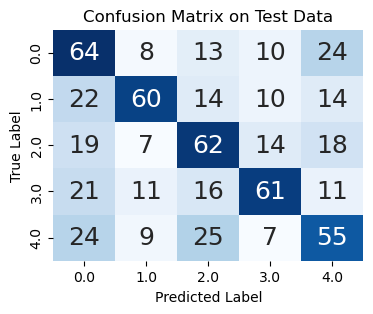

Accuracy on Validation Data: 0.451505016722408


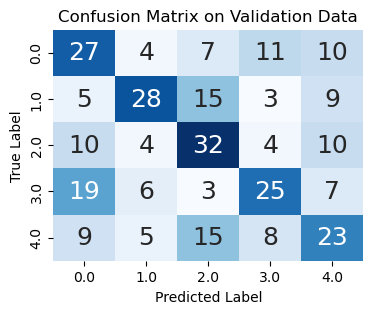

Accuracy on Train Data: 0.5350166746069557


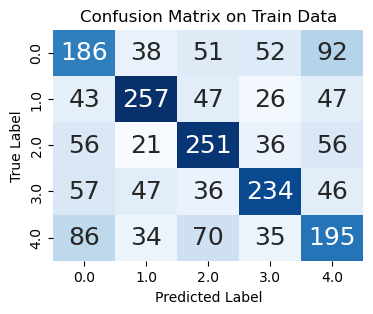

In [9]:
# Estimate the Gaussian parameters from the training data
# params, params_avg_cov = estimate_gaussian_parameters(x_train, y_train)
print("\nCovariance matrices for all the classes are the same\n")
# Run Bayes classifier for test, validation, and training data
for dataset_name, x_data, y_data in [("Test Data", x_test, y_test), 
                                     ("Validation Data", x_val, y_val), 
                                     ("Train Data", x_train, y_train)]:
    
    # Predict using Bayes classifier for different Covariance
    predictions = bayes_classifier(x_train, y_train, x_data, params_avg_cov)
    
    # Evaluate the classifier
    evaluate_classifier(y_data, predictions, dataset_name)


<h1>b. Covariance matrices are different<h1>

In [10]:
train_predictions = bayes_classifier(x_train, y_train, x_train, params)
val_predictions = bayes_classifier(x_train, y_train, x_val, params)
test_predictions = bayes_classifier(x_train, y_train, x_test, params)

# Calculate accuracy for each dataset
train_accuracy = evaluate_accuracy(y_train, train_predictions)
val_accuracy = evaluate_accuracy(y_val, val_predictions)
test_accuracy = evaluate_accuracy(y_test, test_predictions)

# Create a dictionary to hold the data
data = {
    'Dataset': ['Train', 'Validation', 'Test'],
    'Size': [len(x_train), len(x_val), len(x_test)],
    'Accuracy': [train_accuracy, val_accuracy, test_accuracy]
}

# Create a pandas DataFrame
df = pd.DataFrame(data)

# Display the table
print(df)

      Dataset  Size  Accuracy
0       Train  2099  0.718914
1  Validation   299  0.464883
2        Test   599  0.505843



Covariance matrices are different

Accuracy on Test Data: 0.5058430717863105


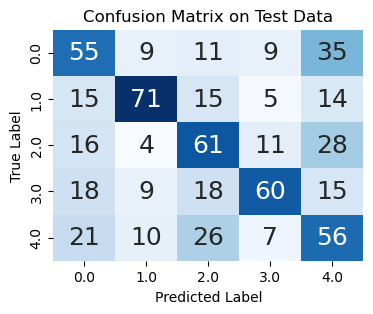

Accuracy on Validation Data: 0.46488294314381273


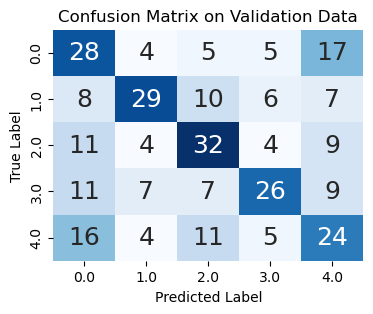

Accuracy on Train Data: 0.7189137684611719


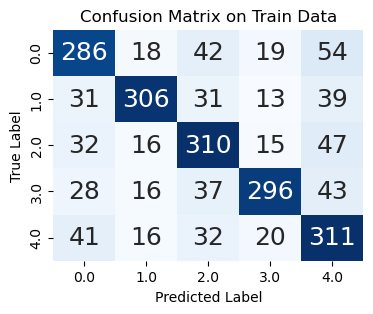

In [11]:

print("\nCovariance matrices are different\n")

# Run Bayes classifier for test, validation, and training data
for dataset_name, x_data, y_data in [("Test Data", x_test, y_test), 
                                     ("Validation Data", x_val, y_val), 
                                     ("Train Data", x_train, y_train)]:
    
    # Predict using Bayes classifier for different Covariance
    predictions = bayes_classifier(x_train, y_train, x_data, params)
    
    # Evaluate the classifier
    evaluate_classifier(y_data, predictions, dataset_name)